<a href="https://colab.research.google.com/github/HariPrabu741/Project/blob/main/Chest_x_ray_Type_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install kaggle
!pip install kaggle

In [3]:
from google.colab import files

In [4]:
# Uploading json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hariprabu","key":"bb3af12feb4c1e923a55d9df2eefee60"}'}

In [5]:
# Creating kaggle folder
!mkdir -p ~/.kaggle

In [6]:
# Copying kaggle json file to kaggle folder 
!cp kaggle.json ~/.kaggle/

In [7]:
# Permission for json to activate
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Paste the copyed api comment of dataset from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 47.5MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.5MB/s]


In [9]:
# Unzip the zip file
!unzip -q '/content/chest-xray-pneumonia.zip'

In [10]:
# Import packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [20]:
# Creating path for all data
train_path=Path("/content/chest_xray/train")
test_path=Path("/content/chest_xray/test")
val_path=Path("/content/chest_xray/val")

In [21]:
# Collecting all the path inside 'NORMAL' and 'PNEUMONIA'
train_img_path=train_path.glob("*/*")
val_img_path=val_path.glob("*/*")

print(train_img_path)  # Output of glob always be generator object so we have to convert it to list

<generator object Path.glob at 0x7fee1f31cf50>


In [22]:
# Created list to access img path
train_img_path=list(train_img_path)
val_img_path=list(val_img_path)

print(train_img_path[:2])  # output is in posixpath. Need to convert posixpath to string.

[PosixPath('/content/chest_xray/train/NORMAL/IM-0546-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/IM-0637-0001.jpeg')]


In [23]:
# Convert posix path to normal path(str)
train_img_path=list(map(lambda x:str(x), train_img_path))
val_img_path=list(map(lambda x:str(x),val_img_path))

print(train_img_path[:2])

['/content/chest_xray/train/NORMAL/IM-0546-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0637-0001.jpeg']


In [24]:
# Collecting length for train & val data
train_len=len(train_img_path)
val_len=len(val_img_path)

print("train_len :",train_len,'\n'"val_len :",val_len)

train_len : 5216 
val_len : 16


In [25]:
# Every path has its label name... so creating label and inverse label

label={'NORMAL':0,'PNEUMONIA':1}
inv_label={0:'NORMAL',1:'PNEUMONIA'}

In [26]:
# Creating labels for train and validation by function and lambda

def get_label(path):
  return label[path.split('/')[-2]]    #It will return only the -2 index (normal[0] or pneumonia[1])

train_label=list(map(lambda x : get_label(x), train_img_path))
val_label=list(map(lambda x : get_label(x), val_img_path))

print(train_label[0:3])

[0, 0, 0]


## Data Augmentation by tensorflow data object

In [19]:
# Function used for transformation and data augmentation

def load_and_transform(image, label, train=True):
  image=tf.io.read_file(image)                                   #1.read the image
  image=tf.io.decode_jpeg(image,channels=3)                      #2.then decode the image type
  image=tf.image.resize(image, [224,224], method="nearest")      #3.resize the image
  if train:
    image=tf.image.random_flip_left_right(image)                 #4.data augmentation(here only 1 aug... is used)
  return image,label

In [43]:
# Function used to create tensorflow data object

def get_dataset(path, label, train=True):
  image_path=tf.convert_to_tensor(path)                                       #1.Converting path to tensor(o/p--str)
  label=tf.convert_to_tensor(label)                                           #1.Converting label to tensor
  image_dataset=tf.data.Dataset.from_tensor_slices(image_path)                #2.slicing tensors to dataset
  label_dataset=tf.data.Dataset.from_tensor_slices(label)                     #2.slicing tensors to dataset

  dataset=tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)   #3.combining path and labels with shuffle
  dataset=dataset.map(lambda image,label : load_and_transform(image,label))
  dataset=dataset.repeat()
  dataset=dataset.shuffle(1000)
  dataset=dataset.batch(32)                                                   #4.creating batch size for dataset

  return dataset



(32, 224, 224, 3)
(32,)


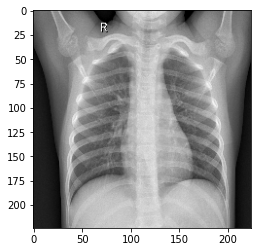

In [45]:
# Creating train dataset object and verifying it

train_dataset=get_dataset(train_img_path, train_label)       #1.creating training dataset

image,label=next(iter(train_dataset))                        #2.next(iter())----it is the important step for verification   
print(image.shape)
print(label.shape)

plt.imshow(image[0].numpy().reshape(224,224,3))

In [58]:
inv_label[label[0].numpy()]

'NORMAL'

(32, 224, 224, 3)
(32,)
PNEUMONIA


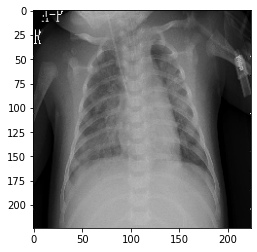

In [51]:
# Creating val... data object and verifying it

val_dataset=get_dataset(val_img_path,val_label)          #1.creating validation dataset
image, label= next(iter(val_dataset))                    #2.important step for verification
print(image.shape)
print(label.shape)
print(inv_label[label[15].numpy()])
plt.imshow(image[15].numpy().reshape(224,224,3))

Here we are not goint to create the model with simple convolution network--- instead we use ResNet.

Issues using plain conv. network :--

(i) Adding more layers can lead to more complex like overfitting. 

(ii) Deeper network might face an issue backpropagating the gradiants. This issue is called as vanishing gradiant problem.

Solutions :--

(i) Overfitting can be handled by using regularization and dropout where we deactivate few random neurons.

(ii) 'Vanishing gradiant' problem can be handeled by relu activation which maximize the gradient flow as well as batchnormalization can be used. 


If we use ResNet the validation error can be reduced.

In [64]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

In [65]:
api=ResNet50V2(include_top=False, input_shape=(224,224,3))

94683136/94668760 [==============================] - 3s 0us/step


In [66]:
model = tf.keras.Sequential([api, tf.keras.layers.GlobalAveragePooling2D(), 
                             tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [67]:
#Compiling model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

CallBacks


Earlystopping callback can be used to stop the training process before model tries to overlearn.

Modelcheckpoint callback will save only the best model or its weight at perticular frequency.

In [75]:
from tensorflow.python.ops.gen_io_ops import save
# Creating callbacks

checkpoints=tf.keras.callbacks.ModelCheckpoint("pneumonia_best_weight.h5",monitor='loss', verbose=1,save_best_only=True,save_weights_only=True)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [76]:
# Training the model
history=model.fit(train_dataset,
                  steps_per_epoch=train_len//32,
                  epochs=20,
                  callbacks=[checkpoints,early_stop],
                  validation_data=val_dataset,
                  validation_steps=val_len//32)

Epoch 1/20
163/163 [==============================] - 145s 805ms/step - loss: 0.1044 - accuracy: 0.9653

Epoch 00001: loss improved from inf to 0.10439, saving model to pneumonia_best_weight.h5
Epoch 2/20
163/163 [==============================] - 134s 823ms/step - loss: 0.0528 - accuracy: 0.9799

Epoch 00002: loss improved from 0.10439 to 0.05283, saving model to pneumonia_best_weight.h5
Epoch 3/20
163/163 [==============================] - 135s 826ms/step - loss: 0.0550 - accuracy: 0.9804

Epoch 00003: loss did not improve from 0.05283
Epoch 4/20
163/163 [==============================] - 136s 832ms/step - loss: 0.0579 - accuracy: 0.9774

Epoch 00004: loss did not improve from 0.05283
Epoch 5/20
163/163 [==============================] - 136s 831ms/step - loss: 0.0544 - accuracy: 0.9803

Epoch 00005: loss did not improve from 0.05283
Epoch 6/20
163/163 [==============================] - 136s 833ms/step - loss: 0.0437 - accuracy: 0.9826

Epoch 00006: loss improved from 0.05283 to 0.04

In [77]:
# load the model & Saving the model

model.load_weights('pneumonia_best_weight.h5')
model.save('pneumonia_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [81]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


#### Creating a test model

In [12]:
test_path  #test path

PosixPath('/content/chest_xray/test')

In [13]:
test_img_path=test_path.glob('*/*')   #used to pass the path of sub-files
test_img_path

<generator object Path.glob at 0x7fee1f3a6d50>

In [14]:
test_img_path=list(test_img_path)     #viewing image file
test_img_path[0]

PosixPath('/content/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg')

In [15]:
test_img_path=list(map(lambda x : str(x),test_img_path))     #converting the path to string
test_img_path[0]

'/content/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg'

In [27]:
test_label=list(map(lambda x : get_label(x), test_img_path))   #creating labels for test path
print(test_label[0:3])

[0, 0, 0]


In [28]:
# Loading image

def load_img(image,label):
  image=tf.io.read_file(image)
  image=tf.io.decode_jpeg(image,channels=3)
  image=tf.image.resize(image,[224,224],method="nearest")
  return image,label

In [29]:
img_path=tf.convert_to_tensor(test_img_path)
label=tf.convert_to_tensor(test_label)

test_dataset=(tf.data.Dataset.from_tensor_slices((img_path,label)).map(load_img).batch(32))


(32, 224, 224, 3)
(32,)
NORMAL


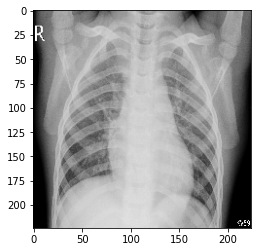

In [33]:
# verify test dataset
img,label=next(iter(test_dataset))
print(img.shape)
print(label.shape)

print(inv_label[label[0].numpy()])
plt.imshow(img[0].numpy().reshape(224,224,3))

In [34]:
#test_dataset= tf.data.Dataset.from_tensor_slices(test_img_path,test_label)

In [38]:
loaded_model=tf.keras.models.load_model('pneumonia_model.h5')

In [39]:
loss,acc=loaded_model.evaluate(test_dataset)

20/20 [==============================] - 86s 4s/step - loss: 5.8043 - accuracy: 0.4904


In [40]:
print(loss)
print(acc)

5.80427885055542
0.49038460850715637
